# The GTZAN Dataset for music genre classification (and more)

The GTZAN Dataset (http://marsyas.info/downloads/datasets.html) was collected between 2000 and 2001, and used for the paper in genre classification " Musical genre classification of audio signals " by G. Tzanetakis and P. Cook in IEEE Transactions on Audio and Speech Processing 2002. Since then, it has been a popular choice for subsequent work on musical genre classification using machine learning.

The instance of the dataset used in this notebook has been imported from Kaggle (https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification) as curated by Andrada Olteanu. In this form, the accompanying csv dataframe conveniently contains an abundance of features extracted from each audio file using the librosa python library.

This dataset has been mostly associated with music genre classification, a task that has lately been taken over entirely by deep learning models and convolutional neural networks. 
However, as specifying a genre for a song and its performer can be a very nebulous affair, given its subjective nature, even the most precise audio-based models often fail to reach a high accuracy. Especially when it comes to drawing boundaries between wide-reaching genres such as rock and pop, this precision becomes a matter of correct labeling as much as it is a matter of designing a good model.

Shifting away from genre classification, the goal of this small project will be to eventually create a recommendation model. In particular, it should be a recommendation based solely on the audio content of the song, uninfluenced by subjective associations not directly stemming from its sound. 

The structure followed is:

*   An exploration of the features used to characterize each song in the database, what they correspond to at a high level, and how they might correlate to each other.
*   A Genre Classification model is built based on these extracted features, using a Cross Gradient Booster, which is one of the most powerful and accurate 'conventional' machine learning algorithms. The goal of this is to obtain the importance of such features when performing a classification task, so that only the most insightgul are used in the recommendation algorithm.
*   The recommendation algorithm is defined, using a few selected features and cosine similarity as a metric of how similar sounding songs are to each other. 

Credit should go to Andrada Olteanu who uploaded the dataset in this form on Kaggle, and has provided well documented examples of how the features were extracted, as well as for most of the tasks carried out in this work.





*In order to access the sound files comprising the GTZAN dataset, the notebook connects to Kaggle to download the files (~1.3 GB). However, one can run most of the code and train the models without accessing these files, as long as the Dataframe containing the extracted feature values is available.*

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
od.download('https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nkode611
Your Kaggle Key: ··········


  1%|          | 9.00M/1.21G [00:00<00:21, 60.4MB/s]

100%|██████████| 1.21G/1.21G [00:08<00:00, 158MB/s]


*Install eli5 (used to obtain feature importance)*

In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 4.4MB/s 


*Library Dependencies*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import librosa
import librosa.display

from sklearn.preprocessing import minmax_scale

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance

import IPython.display as ipd

from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# A. Audio Feature Engineering

The GTZAN dataset has the songs arranged by directory according to their classified genre. 10 genres are included, each encompassing 100 songs to make a total of 1000 songs.

In [ ]:
# View genre specific directories
general_path = '/content/gtzan-dataset-music-genre-classification/Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['rock', 'jazz', 'metal', 'disco', 'pop', 'country', 'classical', 'hiphop', 'blues', 'reggae']


## a. Accessing audio files

The 1st entry of the blues directory will be used to provide examples of the features. Here is the waveform of the song as it exists in the dataset. 

Every audio file has a duration of approximately 30 s and a sample rate of 22.05 kHz, which is a librosa standard. This should allow for an adequate amount of information for the tasks ahead, while minimizing disk space.

Sample Rate [Hz]: 22050 
 Duration [s]: 30.013333333333332


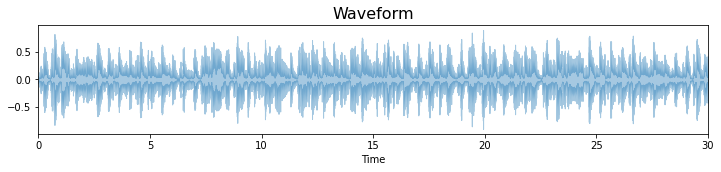

In [ ]:
# Full path to the first blues song
filepath = '/content/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav'

# Import audio example
y, sr = librosa.load(filepath, sr = None)
# Visualize the waveform
plt.figure(figsize = (12, 2))
librosa.display.waveplot(y, sr,alpha=0.4)
plt.title("Waveform", fontsize = 16);
# Print information
print('Sample Rate [Hz]:', sr, '\n', 'Duration [s]:', len(y) / sr)

### 1. Tempo 

The 'speed' of a song, measured in beats per minute:

In [ ]:
# Tempo 
tempo = librosa.beat.tempo(y)
print('Tempo [BPM]: ', tempo)

Tempo [BPM]:  [123.046875]


### 2. Harmonic and Percussive components

An audio time series can be decomposed into harmonic and percussive components. This can be viewed as separating features tied to pitch/frequency from features tied to time.

In [ ]:
# Harmonic and Percussive Components
harmony, percuss = librosa.effects.hpss(y)

print('Harmonic Mean: ', np.mean(harmony), '\n', 'Harmonic Variance: ', np.var(harmony))
print('Percussive Mean: ', np.mean(percuss), '\n', 'Percussive Variance: ', np.var(percuss))

Harmonic Mean:  -4.5297264e-05 
 Harmonic Variance:  0.008172282
Percussive Mean:  7.783232e-06 
 Percussive Variance:  0.005698182


### 3. Chroma STFT. 

From Wikipedia:

*In music, the term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.*

Chroma STFT Mean:  0.35008812 
 Chroma STFT Variance:  0.08875657


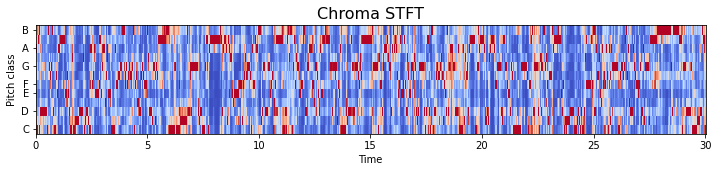

In [ ]:
# Chroma STFT
chroma_stft = librosa.feature.chroma_stft(y, sr)
# Visualize
plt.figure(figsize = (12, 2))
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma',cmap='coolwarm')
plt.title("Chroma STFT", fontsize = 16);
# Mean and Variance
print('Chroma STFT Mean: ', np.mean(chroma_stft), '\n', 'Chroma STFT Variance: ', np.var(chroma_stft))

### 4. Spectral Centroid 

From Wikipedia:

*The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.*

In [ ]:
# Helper function to normalize audio data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

Spectral Centroid Mean:  1784.1658495387549 
 Spectral Centroid Variance:  129774.06452515078


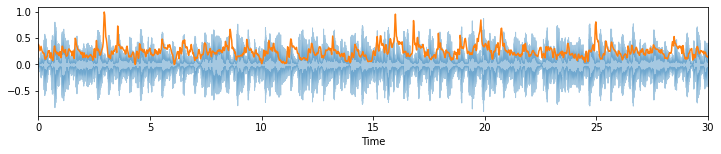

In [ ]:
# Spectral Centroid
spectral_centroid = librosa.feature.spectral_centroid(y, sr)[0]

t = librosa.frames_to_time(range(len(spectral_centroid)))

plt.figure(figsize = (12, 2))
librosa.display.waveplot(y, sr=sr, alpha=0.4);
plt.plot(t, normalize(spectral_centroid));

print('Spectral Centroid Mean: ', np.mean(spectral_centroid), '\n', 'Spectral Centroid Variance: ', np.var(spectral_centroid))

### 5. Zero Crossing Rate 

The rate at which the waveform 'crosses' the zero value.

In [ ]:
# Zero Crossing Rate
zero_crossing_rate = librosa.feature.zero_crossing_rate(y, sr)

print('Zero Crossing Rate Mean: ', np.mean(zero_crossing_rate), '\n', 'Zero Crossing Rate Variance: ', np.var(zero_crossing_rate))

# Total zero_crossings in selected sample
zero_crossings = librosa.zero_crossings(y, pad=False)
print('Total number of zero crosings: ',sum(zero_crossings))

Zero Crossing Rate Mean:  0.0823932460326229 
 Zero Crossing Rate Variance:  0.0002250008874842592
Total number of zero crosings:  55031


### 6. Mel Frequency Ceptstral Coefficients 

A very popular feature for audio processing when it comes to deep learning. Wikipedia can explain:

*Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.*

MFCC Means: [-113.57065, 121.57179, -19.168142, 42.36642, -6.364664, 18.623499, -13.704891, 15.34315, -12.27411, 10.976572, -8.326573, 8.803793, -3.6723, 5.747995, -5.162882, 0.75273985, -1.6902149, -0.40897894, -2.3035226, 1.2212901]
MFCC Variances: [2564.2075, 295.91382, 235.57443, 151.1069, 167.9348, 89.18084, 67.6605, 68.93258, 82.2042, 63.38631, 61.773087, 51.24412, 41.217415, 40.554478, 49.775425, 52.42091, 36.52407, 41.597103, 55.062923, 46.93603]


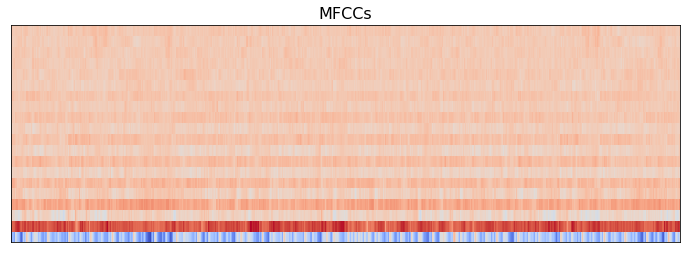

In [ ]:
# MFCCs
mfcc = librosa.feature.mfcc(y, sr, n_mfcc=20)

mfcc_mean = []
mfcc_var = []
# Get list of mean and var for each component:
for n in range(20):
    mfcc_mean.append(np.mean(mfcc[n,:]))
    mfcc_var.append(np.var(mfcc[n,:]))
# Visualization
plt.figure(figsize = (12, 4))
librosa.display.specshow(mfcc)
plt.title("MFCCs", fontsize = 16);

print('MFCC Means:', mfcc_mean)
print('MFCC Variances:', mfcc_var)

## b. Creating a Feature dataframe

A dataframe can be assembled using the above features. The following functions are a breakdown of the pipeline used to generate this dataframe.

In [ ]:
def initialize_dataframe():
  '''
  Initializes an empty dataframe with columns for the features to be extracted,
  plus the filenames and genre labels
  '''
  # Features to be inlcuded:
  columns = ['filename', 
           'tempo',
           'harmonic_mean',
           'harmonic_var',
           'percussive_mean',
           'percussive_var',
           'chroma_stft_mean',
           'chroma_stft_var',
           'spectral_centroid_mean',
           'spectral_centroid_var',
           'zero_crossing_rate_mean',
           'zero_crossing_rate_var'
           ]
  # MFCCs from 1 to 20
  columns.extend([f'mfcc_{i+1}_mean' for i in range(20)])
  columns.extend([f'mfcc_{i+1}_var' for i in range(20)])
  # Add labels (genre) column
  columns.extend(['genre'])
  # Generate the empty dataframe
  dataframe = pd.DataFrame(columns = columns)

  return dataframe

In [ ]:
def extract_features(root, file, feat_cols):
  '''
  Extracts all features from an audio file and stores them in a dataframe to be
  used as a single row.
  '''
  # Load file (sr = 22050 by default)
  y, sr = librosa.load(root+file)
  # Calculate tempo
  tempo = librosa.beat.tempo(y)[0]
  # Calculate harmonic and percussive components
  harmonic, percussive = librosa.effects.hpss(y)
  # Calculate chroma STFT
  chroma_stft = librosa.feature.chroma_stft(y)
  # Calculate spectral centroid
  spectral_centroid = librosa.feature.spectral_centroid(y)[0]
  # Calculate zero crossing rate
  zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
  # Make features list up til now
  features = [filename,
              tempo,
              np.mean(harmonic),
              np.var(harmonic),
              np.mean(percussive),
              np.var(percussive),
              np.mean(chroma_stft),
              np.var(chroma_stft),
              np.mean(spectral_centroid),
              np.var(spectral_centroid),
              np.mean(zero_crossing_rate),
              np.var(zero_crossing_rate)
              ]

  # Calculate the MFCCs
  mfcc = librosa.feature.mfcc(y, sr, n_mfcc=20)

  mfcc_mean = []
  mfcc_var = []
  # Get list of mean and var for each component:
  for n in range(20):
    mfcc_mean.append(np.mean(mfcc[n,:]))
    mfcc_var.append(np.var(mfcc[n,:]))

  # Add the MFCCs to the feature list
  features.extend(mfcc_mean)
  features.extend(mfcc_var)
  
  # Add the genre to the list, taken from the filename
  genre = filename.partition('.')[0]
  features.extend([genre])

  # Store everything in dataframe format
  temp_df = pd.DataFrame(columns = feat_cols, data = [features])

  return temp_df

In [ ]:
def GTZAN_feature_dataframe(audio_path):
  '''
  Creates a dataframe for all the songs in the dataset, and populates it with
  by extracting audio features for each. 
  '''
  # Initialize dataframe
  df = initialize_dataframe()

  # Go through every audio file in the dataset and extract features
  for root, dirs, files in os.walk(audio_path, topdown=False):
    for name in files:

      filepath = (os.path.join(root, name))
      # Create a temporary single row dataframe of features
      temp_df = extract_features(filepath)
      # Add new entry as a row to the main dataframe
      df.append(temp_df, ignore_index = True)

  return df

Using these functions the dataframe can be generated in a single call, given the path to the audio dataset as an argument:

In [ ]:
# Path to dataset audio files
audio_path = '/content/gtzan-dataset-music-genre-classification/Data/genres_original'
# Generate dataframe
df = GTZAN_feature_dataframe(audio_path)
# Save as .csv

df_path = 'df_features.csv'

df.to_csv(df_path, index=False) 

Now that the features are all stored in a dataframe, it can easily be read in:

In [ ]:
df = pd.read_csv(df_path)
df.head()

,filename,tempo,harmonic_mean,harmonic_var,percussive_mean,percussive_var,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,zero_crossing_rate_mean,zero_crossing_rate_var,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,blues.00000.wav,123.046875,-4.529724e-05,0.008172,0.000008,0.005698,0.350088,0.088757,1784.165850,129774.064525,0.083045,0.000767,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,67.999589,1.395807e-04,0.005099,-0.000178,0.003063,0.340914,0.094980,1530.176679,375850.073649,0.056040,0.001448,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,161.499023,2.105576e-06,0.016342,-0.000019,0.007458,0.363637,0.085275,1552.811865,156467.643368,0.076291,0.001007,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,63.024009,4.583644e-07,0.019054,-0.000014,0.002712,0.404785,0.093999,1070.106615,184355.942417,0.033309,0.000423,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,135.999178,-1.756129e-05,0.004814,-0.000010,0.003094,0.308526,0.087841,1835.004266,343399.939274,0.101461,0.001954,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


The correlation matrix can be computed for features in the dataframe. The variance values are not considered in this example, and for convenience of conclusions the absolute value of the correlations is displayed.

Absolute correlation near zero indicates that features are independent from each other. 

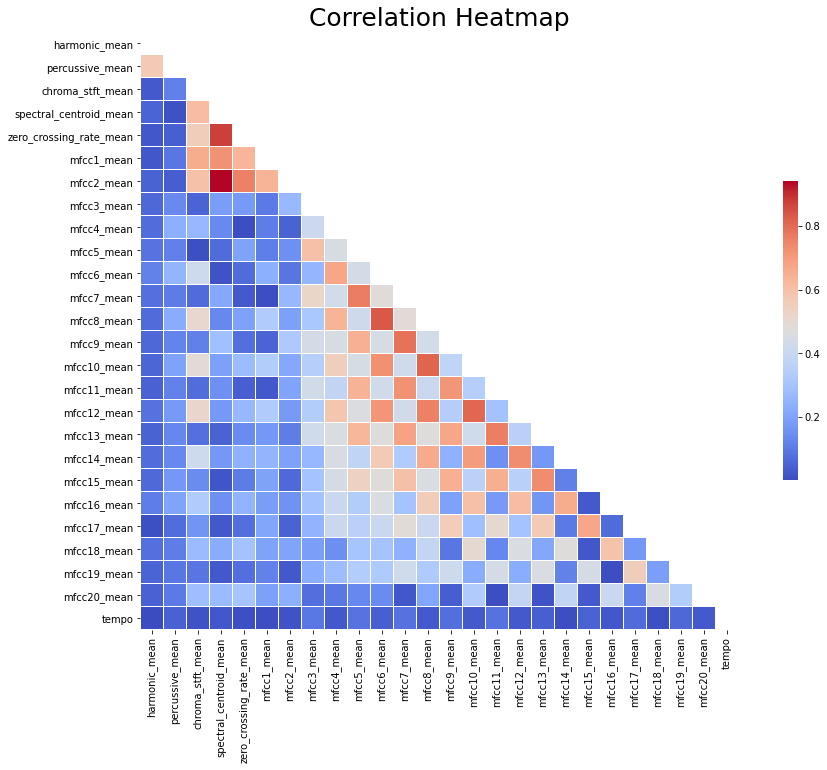

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
spike_cols.append('tempo')
corr = np.abs(df[spike_cols].corr())

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

This concludes an overview of the features included in this dataframe. Next step is to use these features and the labels assigned to each song, to build a genre classifier.

# Genre Classification with Cross Gradient Boosting

In this section, a music genre classifier will be built using the features extracted from 30 second long audio samples, and displayed in the dataframe. 

It is often sought after to work with shorter samples as it reduces storage space, and in general an audio AI model will be considered superior if it can extract information from a smalled sample. Moreover, if features are values averaged over a time span, using a brief excerpt ensures these mean values are more indicative of the content that exists in the entire sample.

However, the task here is to find similar sounding songs, and very brief segments of a song might often prove to be quite uncharacteristic of its overall character. Therefore, the 30 second samples will be used. It is optimistically anticipated that these changes will be adequately expressed by the variance features.

In [44]:
# Read GTZAn dataframe:
df = pd.read_csv(df_path)
# Discard filename and duration:
df = df.iloc[0:, 2:] 

df.head()

,harmonic_mean,harmonic_var,percussive_mean,percussive_var,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,zero_crossing_rate_mean,zero_crossing_rate_var,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,-4.529724e-05,0.008172,0.000008,0.005698,0.350088,0.088757,1784.165850,129774.064525,0.083045,0.000767,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,1.395807e-04,0.005099,-0.000178,0.003063,0.340914,0.094980,1530.176679,375850.073649,0.056040,0.001448,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,2.105576e-06,0.016342,-0.000019,0.007458,0.363637,0.085275,1552.811865,156467.643368,0.076291,0.001007,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,4.583644e-07,0.019054,-0.000014,0.002712,0.404785,0.093999,1070.106615,184355.942417,0.033309,0.000423,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,-1.756129e-05,0.004814,-0.000010,0.003094,0.308526,0.087841,1835.004266,343399.939274,0.101461,0.001954,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Features are separated from the labels (Genres):

In [45]:
# Create Feature and Label dataframes:

y = df['genre'] 
X = df.loc[:, df.columns != 'genre'] 

# Normalize features:
cols = X.columns
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)

Training dataset and Testing dataset split:

In [46]:
# Train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Helper functions for cross validation and final assessment of the model:

In [47]:
# Helper Functions: 

# Print cross-validation results
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

# Fit and make predictions
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

The classifier to be used is the Cross Gradient Booster. 5-fold cross validation is performed to estimate the optimum hyperparameters. (This is a process that might take a while, depending on the parameters set to investigate.)

In [ ]:
# Perform Cross Validation on XGB

# Practical to ignore the following warnings:
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Define XGB parameters to test:
xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'mlogloss')
parameters = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [1, 3, 6],
    'learning_rate': [0.01, 0.05, 1]
}

# 5-fold Cross Validation
cv = GridSearchCV(xgb, parameters, cv=5)
cv.fit(X_train, y_train.ravel())

print_results(cv)

BEST PARAMS: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 800}

0.577 (+/-0.076) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 600}
0.586 (+/-0.062) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 800}
0.597 (+/-0.039) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 1000}
0.669 (+/-0.041) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600}
0.676 (+/-0.058) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 800}
0.677 (+/-0.059) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
0.667 (+/-0.053) for {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 600}
0.667 (+/-0.06) for {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}
0.67 (+/-0.063) for {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
0.643 (+/-0.065) for {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 600}
0.651 (+/-0.07) for {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 800}
0.646 (+/-0.074) for {'

The best performing model is assessed on the test dataset:

In [48]:
# Use best performing XGB:
xgb = XGBClassifier(n_estimators=800, learning_rate=0.05, max_depth=3, eval_metric = 'mlogloss')
model_assess(xgb, "of the Cross Gradient Booster")

Accuracy of the Cross Gradient Booster : 0.725 



The trained model can be saved:

In [ ]:
import pickle

# save
with open('XGB_Music_Genre.pkl','wb') as f:
    pickle.dump(xgb,f)

'''# load
with open('XGB_Music_Genre.pkl', 'rb') as f:
    xgb2 = pickle.load(f)'''

The importance of each feature is calculated:

In [ ]:
# Estimate feature importance using eli5
perm = PermutationImportance(estimator=xgb, random_state=1)
perm.fit(X_test, y_test)

eli5.show_weights(estimator=perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0893 ± 0.0129,percussive_var
0.0280 ± 0.0390,chroma_stft_mean
0.0273 ± 0.0078,mfcc5_var
0.0253 ± 0.0248,mfcc4_mean
0.0247 ± 0.0191,spectral_centroid_var
0.0167 ± 0.0119,zero_crossing_rate_mean
0.0160 ± 0.0065,mfcc13_mean
0.0160 ± 0.0221,percussive_mean
0.0160 ± 0.0186,mfcc6_mean
0.0147 ± 0.0233,mfcc17_mean


Percussiveness and chroma appear to be the best indicators of a song's genre, and presumably, overall character. Many of the MFCCs also display high importance. It is no wonder that very accurate neural networks are trained solely on MFCCs, considering the information that can be contained when all of them are available for analysis across all mel-frequencies.

# Content-based Song Recommendation

A simple recommender system can now be defined to draw information from the audio content of a song through the extracted features, and provide the songs in the database that sound most like it.

For convenience in the next task, the dataframe will be reloaded with the filenames in place the index.

In [ ]:
# Read dataframe, use filename as the index
df = pd.read_csv(df_path, index_col='filename')

df.head()

,tempo,harmonic_mean,harmonic_var,percussive_mean,percussive_var,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,zero_crossing_rate_mean,zero_crossing_rate_var,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
blues.00000.wav,123.046875,-4.529724e-05,0.008172,0.000008,0.005698,0.350088,0.088757,1784.165850,129774.064525,0.083045,0.000767,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
blues.00001.wav,67.999589,1.395807e-04,0.005099,-0.000178,0.003063,0.340914,0.094980,1530.176679,375850.073649,0.056040,0.001448,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
blues.00002.wav,161.499023,2.105576e-06,0.016342,-0.000019,0.007458,0.363637,0.085275,1552.811865,156467.643368,0.076291,0.001007,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
blues.00003.wav,63.024009,4.583644e-07,0.019054,-0.000014,0.002712,0.404785,0.093999,1070.106615,184355.942417,0.033309,0.000423,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
blues.00004.wav,135.999178,-1.756129e-05,0.004814,-0.000010,0.003094,0.308526,0.087841,1835.004266,343399.939274,0.101461,0.001954,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Using the feature importance information obtained from the classification above, only the features that are most indicative of a song's character are utilized in this model.

In [ ]:
# Extract labels
labels = df[['genre']]

# Drop labels from original dataframe
df = df.drop(columns=['genre', ])

# Scale the data
df_scaled=scale(df)

The metric to determine similarity between songs is the cosine similarity between the selected features. A 1000x1000 dataframe, containing the similarity between each song in the database is built.

In [ ]:
# Cosine similarity
similarity = cosine_similarity(df_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

Similarity shape: (1000, 1000)


filename,blues.00000.wav,blues.00001.wav,blues.00002.wav,blues.00003.wav,blues.00004.wav,blues.00005.wav,blues.00006.wav,blues.00007.wav,blues.00008.wav,blues.00009.wav,blues.00010.wav,blues.00011.wav,blues.00012.wav,blues.00013.wav,blues.00014.wav,blues.00015.wav,blues.00016.wav,blues.00017.wav,blues.00018.wav,blues.00019.wav,blues.00020.wav,blues.00021.wav,blues.00022.wav,blues.00023.wav,blues.00024.wav,blues.00025.wav,blues.00026.wav,blues.00027.wav,blues.00028.wav,blues.00029.wav,blues.00030.wav,blues.00031.wav,blues.00032.wav,blues.00033.wav,blues.00034.wav,blues.00035.wav,blues.00036.wav,blues.00037.wav,blues.00038.wav,blues.00039.wav,...,rock.00060.wav,rock.00061.wav,rock.00062.wav,rock.00063.wav,rock.00064.wav,rock.00065.wav,rock.00066.wav,rock.00067.wav,rock.00068.wav,rock.00069.wav,rock.00070.wav,rock.00071.wav,rock.00072.wav,rock.00073.wav,rock.00074.wav,rock.00075.wav,rock.00076.wav,rock.00077.wav,rock.00078.wav,rock.00079.wav,rock.00080.wav,rock.00081.wav,rock.00082.wav,rock.00083.wav,rock.00084.wav,rock.00085.wav,rock.00086.wav,rock.00087.wav,rock.00088.wav,rock.00089.wav,rock.00090.wav,rock.00091.wav,rock.00092.wav,rock.00093.wav,rock.00094.wav,rock.00095.wav,rock.00096.wav,rock.00097.wav,rock.00098.wav,rock.00099.wav
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
blues.00000.wav,1.000000,0.075591,0.558263,0.257113,-0.020695,-0.360158,-0.255145,-0.205543,0.633227,-0.135251,-0.059614,-0.150818,-0.061720,0.105512,-0.169786,-0.149159,-0.016595,-0.018047,-0.062612,-0.123806,0.474353,-0.192742,-0.246415,-0.112764,-0.154482,-0.204870,-0.371121,-0.116349,-0.074911,-0.229369,-0.135764,-0.199171,-0.225218,-0.218035,-0.174630,0.052058,-0.114497,-0.409437,-0.078084,-0.292067,...,-0.089536,-0.301962,-0.465447,-0.614383,0.579633,0.439079,-0.134017,0.304232,0.547744,0.120038,-0.040732,0.614599,0.629100,0.626055,0.743180,0.393266,0.367247,0.535006,0.403727,0.630393,0.488454,0.330112,0.347466,0.712046,0.480855,-0.198525,-0.051727,0.658664,0.249466,0.462943,-0.109654,0.551056,0.572509,0.650253,0.571356,0.613920,0.641184,0.479344,0.245164,0.282241
blues.00001.wav,0.075591,1.000000,-0.089439,0.543202,0.068800,0.278170,0.318561,0.415474,0.131588,0.416077,0.189047,0.502989,0.126176,0.142796,0.377750,0.357813,0.238491,0.297393,0.227268,0.365437,0.171880,0.381380,0.453421,0.039542,0.299556,0.216129,0.269137,0.073814,0.203622,0.292068,0.154719,0.139105,0.290688,0.217236,0.125867,0.117946,0.108767,0.261950,0.209253,0.236253,...,-0.364325,-0.041580,-0.172799,0.367677,-0.162308,-0.086675,0.568218,0.051349,-0.124688,0.027099,-0.083672,-0.000193,-0.073109,-0.182486,-0.126982,0.088631,0.232294,-0.118024,0.224684,-0.227074,-0.232244,0.121908,-0.172638,-0.229324,-0.185373,0.022722,0.231302,-0.270179,-0.121983,0.011805,-0.071064,-0.329744,-0.365062,-0.205084,-0.317976,-0.083594,-0.235055,-0.319421,0.509543,0.288018
blues.00002.wav,0.558263,-0.089439,1.000000,0.128942,0.387314,-0.092627,-0.073328,0.065599,0.447408,-0.170153,0.162867,0.060609,0.129388,-0.074203,-0.262430,-0.192961,-0.015549,-0.060333,-0.334414,-0.069576,0.242353,-0.312820,-0.374702,0.035965,-0.122417,-0.329537,-0.489767,-0.183139,0.015957,0.108423,0.252247,0.213056,0.113114,0.232060,0.287997,0.447048,0.326819,-0.158546,0.279718,0.061491,...,-0.293213,-0.432730,-0.370846,-0.562183,0.694330,0.438574,-0.015668,0.319270,0.501542,0.236054,0.276072,0.442539,0.416396,0.496614,0.506835,0.373865,0.316486,0.488883,0.427847,0.652752,0.484396,0.352820,0.279805,0.581592,0.467245,0.116314,0.125813,0.607414,0.189428,0.555719,-0.058580,0.593411,0.613126,0.580812,0.542432,0.524314,0.596264,0.607625,0.170940,0.322376
blues.00003.wav,0.257113,0.543202,0.128942,1.000000,0.087559,0.099234,0.250339,0.277794,0.357340,0.282346,0.233030,0.398434,0.011174,0.141439,0.174220,0.173265,-0.026878,0.180587,0.035248,0.242568,0.173896,0.167366,0.184290,0.010376,0.280950,0.188692,0.087688,0.090475,0.314906,0.158104,0.089166,0.043994,0.174406,0.063444,0.011179,0.172380,0.0

It is only a matter of defining a simple function to find the highest similarity values for a given song in the above dataframe. The 5 most similar sounding songs are returned as recommendations.

In [ ]:
def find_similar_songs(name):
    # Find songs most similar to another song
    series = sim_df_names[name].sort_values(ascending = False)
    
    # Remove cosine similarity == 1 (songs will always have the best match with themselves)
    series = series.drop(name)
    
    # Display the 5 top matches 
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))
    
    return series.index[:5]

Putting this to the test: 

As an example, song 'rock.00069.wav' is selected. This is an excerpt from 'The Rock Opera' by Jethro Tull. The algorithm will work to find the 5 most similar sounding songs in the dataset.

In [ ]:
# Pick a song from the GTZAN dataset:
song = 'rock.00069.wav'
# Genre of song:
genre = song.partition('.')[0]

# Find 5 most similar songs based off cosine similarity:
similar_songs = find_similar_songs(song) 
# Listen to the selected song:
ipd.Audio(audio_path+'/'+genre+'/'+song)


*******
Similar songs to  rock.00069.wav
filename
rock.00070.wav     0.705171
blues.00070.wav    0.583770
rock.00021.wav     0.565090
rock.00022.wav     0.562676
rock.00067.wav     0.550180
Name: rock.00069.wav, dtype: float64


In [ ]:
# Listen to one of the similar songs:
index = 4
genre = similar_songs[index].partition('.')[0]
ipd.Audio(audio_path+'/'+genre+'/'+similar_songs[index])

The most similar songs according to the recommender are in order: 

1. 'Life's a Long Song', again by Jethro Tull. 

2. Acoustic blues song with traditional instrumentation that I cannot identify (as of yet).

3. Live version of 'Hello Mary Lou' by Queen.

4. Live version of 'Tutti Fruity' by Queen.

5. 'Bungle in the Jungle' by Jethro Tull.

All songs share a common instrumentation of mainly acoustic guitar and male tenor range vocals, plus some folk instruments in some cases. Jethro Tull, the band performing the song originally selected, appear twice in the recommendations list. 

Although the similarity score is not particularly high for any case other than the first, the overall list maintains a common musical theme and tone, and the recommendations do not feel out of place. 

It can be concluded from these results that the recommender system generated based on solely audio content-based features from a 1000 song sample and a simple metric of cosine similarity, is actually rather adequate at its job.